In [3]:
pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.1/417.1 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5

In [14]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [15]:
from langchain_openai import ChatOpenAI

# When we create the functions please add the docstrings, it is very important to LLM to understand

def multiply(a: int, b: int) -> int:
  """ Multiple a and b

  Args:
    a: int
    b: int
  """
  return a * b

def add(a: int, b: int) -> int:
  """Add a and b

  Args:
    a: int
    b: int
  """
  return a + b

def divide(a: int, b: int) -> float:
  """Divide a and b

  Args:
    a: int
    b: int
  """
  return a / b

tools = [add, multiply, divide]

llm = ChatOpenAI(model="gpt-4o")

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [16]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
  messages:Annotated[list[AnyMessage], add_messages]

In [17]:
from langchain_core.messages import HumanMessage, SystemMessage

# System Message
sys_msg = SystemMessage(content="You are helpful assistant tasked with performing arithmetic on a set of inputs")

def assistant(state: MessagesState):
  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

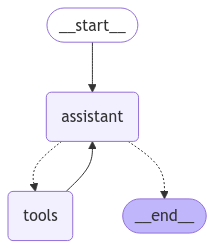

In [18]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import display, Image

builder=StateGraph(MessagesState)

# Define the nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define the edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # if the latest message (result) from assistant is a tool call => tools_condtion routes to tools
    # if the latest message (result) from assistant is not a tool call => tools_condtion routes to END
    tools_condition
)

builder.add_edge("tools","assistant")

react_graph = builder.compile()

display(Image(react_graph.get_graph().draw_mermaid_png()))

In [19]:
messages = [HumanMessage(content="Add 10 and 14. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [20]:
for m in messages["messages"]:
  print(m.pretty_print())

================================ Human Message =================================

Add 10 and 14. Multiply the output by 2. Divide the output by 5
None
================================== Ai Message ==================================
Tool Calls:
  add (call_pdi8e8ShjMN5I0vSv0mZ1i29)
 Call ID: call_pdi8e8ShjMN5I0vSv0mZ1i29
  Args:
    a: 10
    b: 14
None
================================= Tool Message =================================
Name: add

24
None
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KSMDgLpAqJLgjyGr913EiTdg)
 Call ID: call_KSMDgLpAqJLgjyGr913EiTdg
  Args:
    a: 24
    b: 2
None
================================= Tool Message =================================
Name: multiply

48
None
================================== Ai Message ==================================
Tool Calls:
  divide (call_BEllE3pND2IAnL2DoCsOZyiv)
 Call ID: call_BEllE3pND2IAnL2DoCsOZyiv
  Args:
    a: 48
    b: 5
None
==========================

##Memory in Agents using MemorySaver

In [23]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

react_graph=builder.compile(checkpointer=memory)

In [25]:
config = {"configurable": {"thread_id":"1"}}

# Specify an input
messages = [HumanMessage(content="Add 10 and 25")]

# Execute
messages=react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Add 10 and 25
================================== Ai Message ==================================
Tool Calls:
  add (call_fAmz91PZwpwAB1043swRRN4A)
 Call ID: call_fAmz91PZwpwAB1043swRRN4A
  Args:
    a: 10
    b: 25
================================= Tool Message =================================
Name: add

35
================================== Ai Message ==================================

The result of adding 10 and 25 is 35.
================================ Human Message =================================

Add 10 and 25
================================== Ai Message ==================================
Tool Calls:
  add (call_aj2mXZS1LCmjZzs6Q3wRg8Gu)
 Call ID: call_aj2mXZS1LCmjZzs6Q3wRg8Gu
  Args:
    a: 10
    b: 25
================================= Tool Message =================================
Name: add

35
================================== Ai Message ==================================

The result of addi

In [26]:
# Specify an input
messages = [HumanMessage(content="Multiply that by 5")]

# Execute
messages=react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Add 10 and 25
================================== Ai Message ==================================
Tool Calls:
  add (call_fAmz91PZwpwAB1043swRRN4A)
 Call ID: call_fAmz91PZwpwAB1043swRRN4A
  Args:
    a: 10
    b: 25
================================= Tool Message =================================
Name: add

35
================================== Ai Message ==================================

The result of adding 10 and 25 is 35.
================================ Human Message =================================

Add 10 and 25
================================== Ai Message ==================================
Tool Calls:
  add (call_aj2mXZS1LCmjZzs6Q3wRg8Gu)
 Call ID: call_aj2mXZS1LCmjZzs6Q3wRg8Gu
  Args:
    a: 10
    b: 25
================================= Tool Message =================================
Name: add

35
================================== Ai Message ==================================

The result of addi